In [2]:
from collections import defaultdict
from get_vpc_corpus import SEED_VERBS as VERB_TO_COUNT
import numpy as np


def load_vpc_to_year(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year = {}
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            first_occurrence = int(line[3])
            vpc_to_year[curr_vpc] = first_occurrence
    return vpc_to_year


def load_particle_to_count(data_path="vpc_corpus.csv"):
    particle_to_count = defaultdict(int)
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_particle = line[1]
            frequency = int(line[2])
            particle_to_count[curr_particle] += frequency
    return particle_to_count


def normalize_dict(d):
    max_val = np.max(list(d.values()))
    return {k: v / max_val for k, v in d.items()}


PARTICLE_TO_COUNT = normalize_dict(load_particle_to_count())
VERB_TO_COUNT = normalize_dict(VERB_TO_COUNT)
POSSIBLE_VPCS = set([(verb, particle) for verb in VERB_TO_COUNT
                     for particle in PARTICLE_TO_COUNT])
VPC_TO_YEAR = load_vpc_to_year(vpc_vocab=POSSIBLE_VPCS)


In [8]:
# Frequency-based ranking.

# TODO: change this to use decade-specific frequency measures.

def get_verb_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: VERB_TO_COUNT[x[0]] * PARTICLE_TO_COUNT[x[1]],
        reverse=True), "Verb Frequency * Prt Frequency"


def get_verb_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: VERB_TO_COUNT[x[0]],
        reverse=True), "Verb Frequency"


def get_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: PARTICLE_TO_COUNT[x[1]],
        reverse=True), "Prt Frequency"


def get_verb_in_vpc_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    verb_to_n_vpcs = defaultdict(int)
    for curr_verb, _ in known_vpcs:
        verb_to_n_vpcs[curr_verb] += 1
    return sorted(
        novel_vpcs,
        key=lambda x: verb_to_n_vpcs[x[0]], # + VERB_TO_COUNT[x[0]] * PARTICLE_TO_COUNT[x[1]],
        reverse=True), "Verb in VPC ranking"


def get_verb_in_vpc_plus_freq_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    verb_to_n_vpcs = defaultdict(int)
    for curr_verb, _ in known_vpcs:
        verb_to_n_vpcs[curr_verb] += 1
    return sorted(
        novel_vpcs,
        key=lambda x: verb_to_n_vpcs[x[0]] + VERB_TO_COUNT[x[0]] * PARTICLE_TO_COUNT[x[1]],
        reverse=True), "Verb in VPC ranking + VPC frequency"


In [25]:
# Neighbor-based ranking.


import pickle
import numpy as np
from tqdm import trange, tqdm
from sklearn.metrics.pairwise import cosine_similarity


def build_mini_verb_dataset(
        start_decade=1800, end_decade=2000, output_path="verb_vectors"):
    # find all vectors for verbs in VERB_TO_COUNT
    # write them to output_path
    for year in trange(start_decade, end_decade, 10):
        with open(f"sgns/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        curr_vectors = np.load(f"sgns/{year}-w.npy")
        verb_vocab = [item for item in curr_vocab if item in VERB_TO_COUNT]
        verb_embeddings = np.array([
            curr_vectors[i] for i, label in enumerate(curr_vocab)
            if label in VERB_TO_COUNT
        ])
        with open(f"verb_vectors/{year}-vocab.pkl", "wb") as f:
            pickle.dump(verb_vocab, f)
        np.save(f"verb_vectors/{year}-w.npy", verb_embeddings)


def compute_nearest_vpc_verbs_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = np.array([
            np.mean([
                curr_vectors[verb_to_idx[verb]]
                for verb in prt_to_verbs[particle]
                if verb in verb_to_idx], axis=0) 
            for particle in particles])
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            prt_vec = particle_vectors[particle_to_idx[curr_prt]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = cosine_similarity(
                [verb_vec], [prt_vec])[0][0]

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking(
        known_vpcs, year, data_path="nearest_neighbors_prototype.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: year_to_possible_vpcs[year].get(x, -1),
        reverse=True), "Nearest neighbors prototype"


# build_mini_verb_dataset()
# compute_nearest_vpc_verbs_prototype()

In [21]:
print(year_to_possible_vpcs_exemplar[1800][('project', 'on')])
print(year_to_possible_vpcs_proto[1800][('project', 'on')])

0.28607216231195864
0.029075879468542194


In [22]:
def compute_nearest_vpc_verbs_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = {particle: np.array(
            [curr_vectors[verb_to_idx[verb]]
             for verb in prt_to_verbs[particle]
             if verb in verb_to_idx])
            for particle in particles}
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = np.max(cosine_similarity(
                [verb_vec], particle_vectors[curr_prt]))

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking_exemplar(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: year_to_possible_vpcs[year].get(x, -1),
        reverse=True), "Nearest neighbors exemplar"


#compute_nearest_vpc_verbs_exemplar()

In [37]:
with open("levin_1993_data.p", "rb") as f: 
    LEVIN_VERBS = pickle.load(f)[0]
    LEVIN_VERBS = {k: set(v) for k, v in LEVIN_VERBS.items()}
LEVIN_VERB_LIST = list(LEVIN_VERBS.keys())
LEVIN_VERB_TO_IDX = {v: i for i, v in enumerate(LEVIN_VERB_LIST)}
LEVIN_DISTANCES = np.array([[
    len(LEVIN_VERBS[verb1].intersection(LEVIN_VERBS[verb2])) /
    len(LEVIN_VERBS[verb1].union(LEVIN_VERBS[verb2]))
    for verb1 in LEVIN_VERB_LIST]
    for verb2 in LEVIN_VERB_LIST])


def get_ranking_levin_verbs(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):    
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    prt_to_verbs = defaultdict(set)
    for v, prt in known_vpcs:
        prt_to_verbs[prt].add(v)
    
    return sorted(
        novel_vpcs,
        key=lambda x: np.max([
            LEVIN_DISTANCES[LEVIN_VERB_TO_IDX[verb], LEVIN_VERB_TO_IDX[x[0]]]
            for verb in prt_to_verbs[x[1]]
            if verb in LEVIN_VERBS]) if x[0] in LEVIN_VERBS else 0,
        reverse=True), "Levin verbs exemplar"

In [6]:
# Phonological neighbor-based ranking

from tqdm import tqdm, trange
import Levenshtein
import pickle


def compute_nearest_vpc_verbs_phonological_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            mean_sim = np.mean([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = mean_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)
        
        
def compute_nearest_vpc_verbs_phonological_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            max_sim = np.max([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = max_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_phonological_neighbor_ranking(
        known_vpcs, year,
        data_path="phonological_nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return sorted(
        novel_vpcs,
        key=lambda x: year_to_possible_vpcs[year][x],
        reverse=True), "phonological exemplar"

        
# compute_nearest_vpc_verbs_phonological_prototype()
# compute_nearest_vpc_verbs_phonological_exemplar()


100%|██████████| 20/20 [09:29<00:00, 36.62s/it]



100%|██████████| 101/101 [00:02<00:00, 23.51it/s]

100%|██████████| 101/101 [00:01<00:00, 56.79it/s]

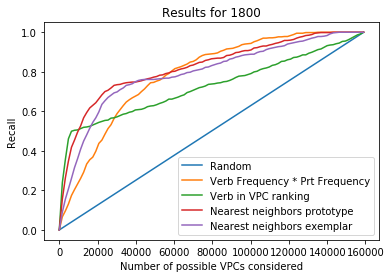


100%|██████████| 101/101 [00:01<00:00, 28.77it/s]

100%|██████████| 101/101 [00:02<00:00, 19.79it/s]


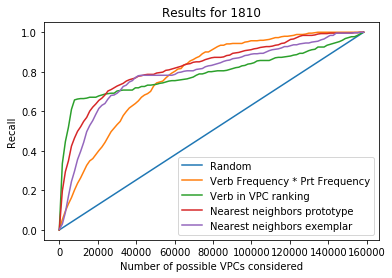


100%|██████████| 101/101 [00:01<00:00, 38.47it/s]

100%|██████████| 101/101 [00:01<00:00, 56.95it/s]

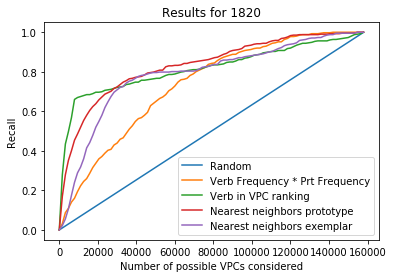


100%|██████████| 101/101 [00:02<00:00, 21.97it/s]

100%|██████████| 101/101 [00:01<00:00, 37.80it/s]

100%|██████████| 101/101 [00:01<00:00, 69.78it/s]

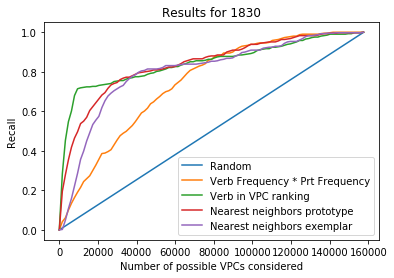


100%|██████████| 101/101 [00:01<00:00, 30.94it/s]

100%|██████████| 101/101 [00:01<00:00, 33.88it/s]


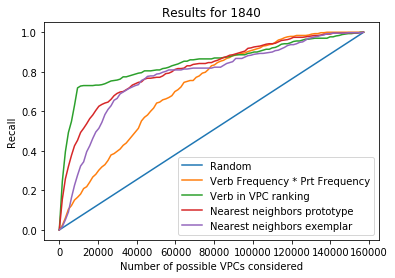


100%|██████████| 101/101 [00:01<00:00, 56.99it/s]

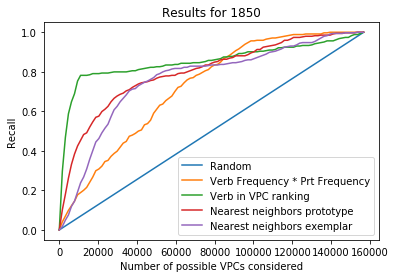


100%|██████████| 101/101 [00:01<00:00, 30.66it/s]

100%|██████████| 101/101 [00:01<00:00, 62.83it/s]

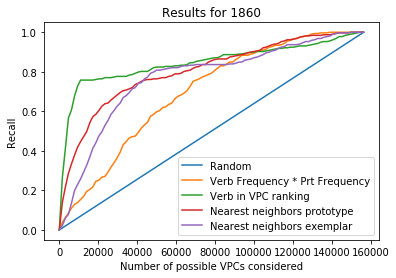


100%|██████████| 101/101 [00:01<00:00, 39.18it/s]


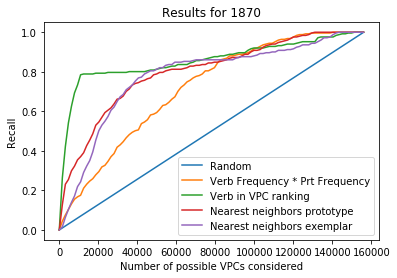


100%|██████████| 101/101 [00:02<00:00, 25.71it/s]

100%|██████████| 101/101 [00:01<00:00, 29.69it/s]


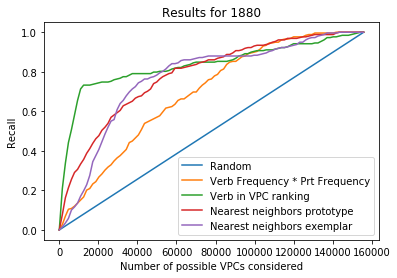


100%|██████████| 101/101 [00:02<00:00, 24.10it/s]

100%|██████████| 101/101 [00:01<00:00, 27.61it/s]

100%|██████████| 101/101 [00:02<00:00, 18.17it/s]


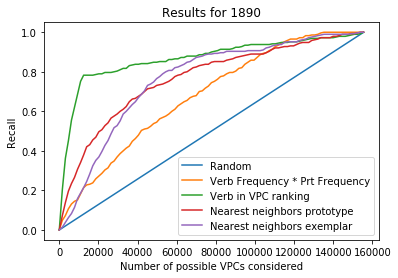


100%|██████████| 101/101 [00:01<00:00, 35.56it/s]


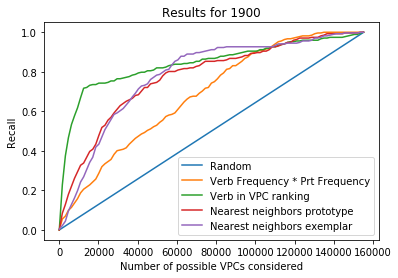


100%|██████████| 101/101 [00:01<00:00, 44.00it/s]


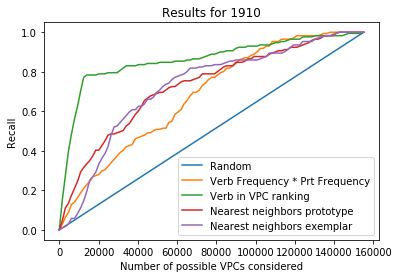


100%|██████████| 101/101 [00:01<00:00, 46.23it/s]


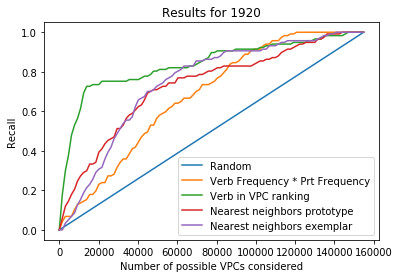


100%|██████████| 101/101 [00:01<00:00, 36.55it/s]

100%|██████████| 101/101 [00:01<00:00, 82.43it/s]

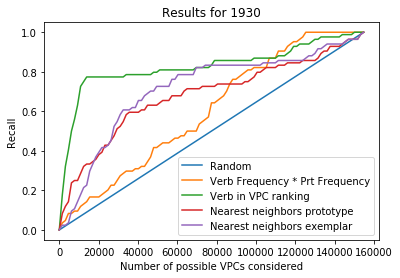


100%|██████████| 101/101 [00:01<00:00, 83.59it/s]

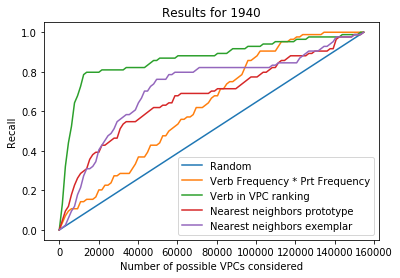


100%|██████████| 101/101 [00:01<00:00, 72.97it/s]

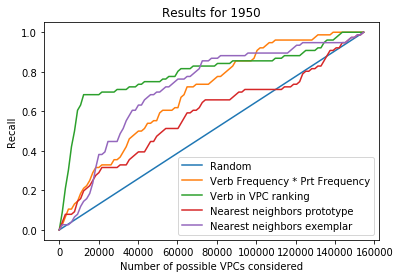


100%|██████████| 101/101 [00:01<00:00, 75.88it/s]

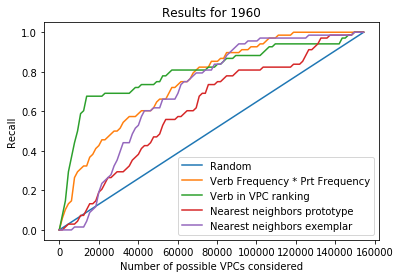


100%|██████████| 101/101 [00:01<00:00, 36.75it/s]

100%|██████████| 101/101 [00:01<00:00, 78.61it/s]

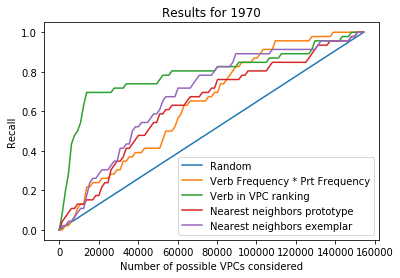


100%|██████████| 101/101 [00:01<00:00, 82.83it/s]

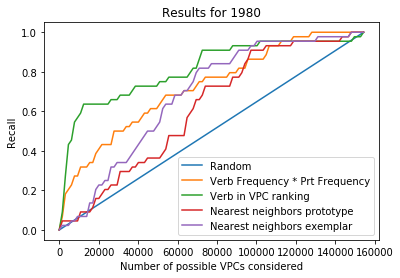


100%|██████████| 101/101 [00:01<00:00, 40.36it/s]


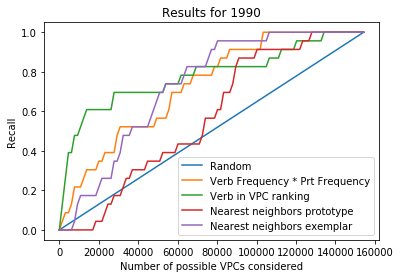

In [41]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_vpcs(novel_vpcs, ranking, ranking_name=None):
    for item in novel_vpcs:
        assert item in ranking, f"{item} not in ranking"
    n_vpcs = list(range(1, len(ranking), len(ranking) // 100))
    recall = []
    for i in tqdm(n_vpcs):
        curr_n_correct = len([item for item in ranking[:i] if item in novel_vpcs])
        recall.append(curr_n_correct / len(novel_vpcs))
    plt.plot(n_vpcs, recall, label=ranking_name)

    
def run_experiment(ranking_functions, start_decade=1800, end_decade=2000):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    for year in range(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        plt.plot([0, len(POSSIBLE_VPCS) - len(known_vpcs)], [0, 1], label="Random")
        for ranking_function in ranking_functions:
            ranking, ranking_name = ranking_function(known_vpcs, year)
            evaluate_vpcs(novel_vpcs, ranking, ranking_name=ranking_name)    
        plt.xlabel("Number of possible VPCs considered")
        plt.ylabel("Recall")
        plt.legend()
        plt.title(f"Results for {year}")
        plt.show()
        known_vpcs.update(novel_vpcs)


run_experiment(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar])


100%|██████████| 101/101 [00:02<00:00, 25.84it/s]

100%|██████████| 101/101 [00:01<00:00, 28.53it/s]


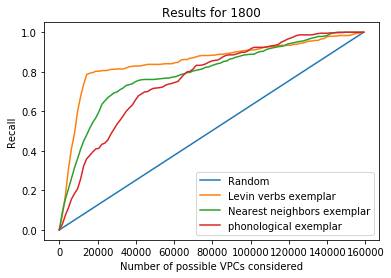


100%|██████████| 101/101 [00:01<00:00, 58.95it/s]

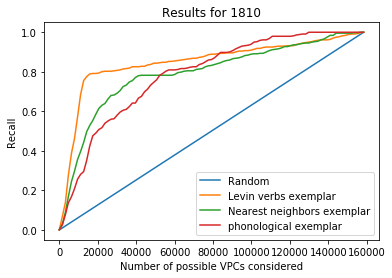


100%|██████████| 101/101 [00:01<00:00, 35.75it/s]


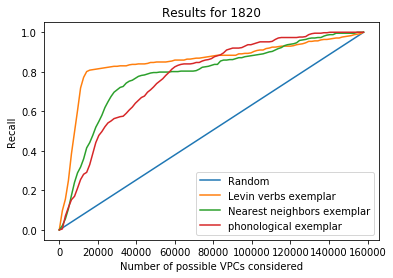


100%|██████████| 101/101 [00:01<00:00, 27.95it/s]

100%|██████████| 101/101 [00:01<00:00, 31.72it/s]


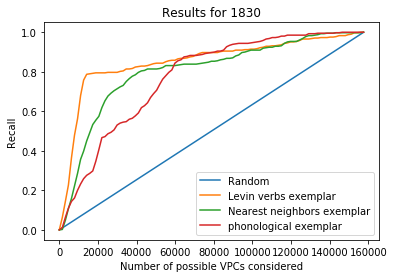


100%|██████████| 101/101 [00:01<00:00, 64.57it/s]

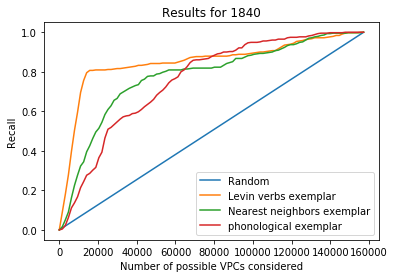


100%|██████████| 101/101 [00:02<00:00, 48.07it/s]

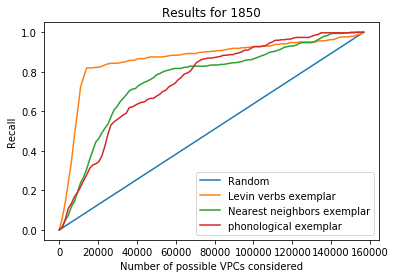


100%|██████████| 101/101 [00:02<00:00, 26.28it/s]

100%|██████████| 101/101 [00:01<00:00, 56.32it/s]

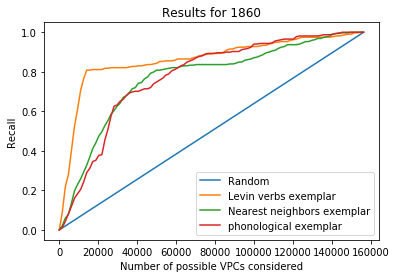


100%|██████████| 101/101 [00:02<00:00, 23.85it/s]

100%|██████████| 101/101 [00:01<00:00, 31.60it/s]

100%|██████████| 101/101 [00:01<00:00, 53.24it/s]

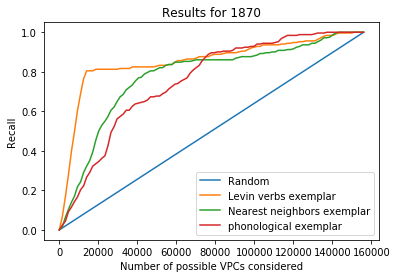


100%|██████████| 101/101 [00:02<00:00, 23.32it/s]

100%|██████████| 101/101 [00:01<00:00, 52.36it/s]

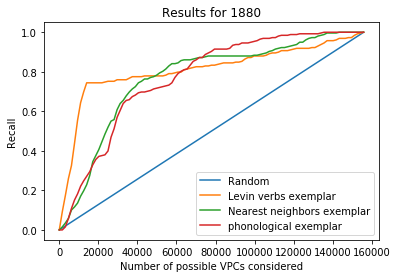


100%|██████████| 101/101 [00:02<00:00, 25.31it/s]

100%|██████████| 101/101 [00:01<00:00, 59.22it/s]

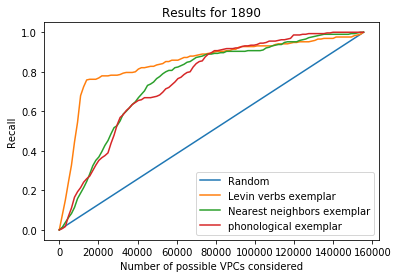


100%|██████████| 101/101 [00:01<00:00, 27.10it/s]


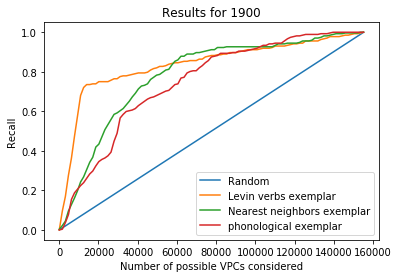


100%|██████████| 101/101 [00:01<00:00, 35.30it/s]

100%|██████████| 101/101 [00:01<00:00, 58.98it/s]

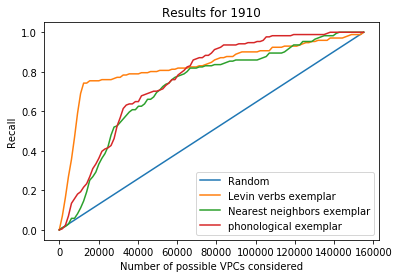


100%|██████████| 101/101 [00:01<00:00, 57.21it/s]

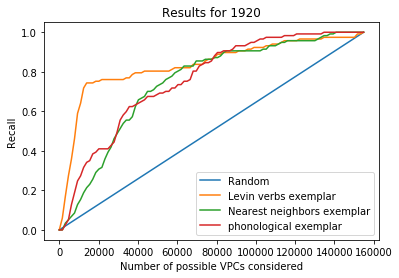


100%|██████████| 101/101 [00:01<00:00, 52.54it/s]

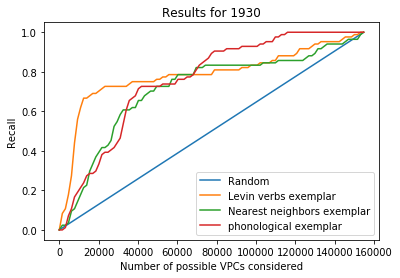


100%|██████████| 101/101 [00:01<00:00, 61.73it/s]

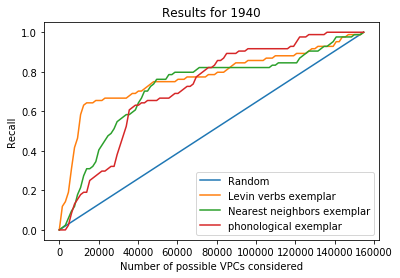


100%|██████████| 101/101 [00:02<00:00, 25.73it/s]

100%|██████████| 101/101 [00:01<00:00, 35.70it/s]

100%|██████████| 101/101 [00:01<00:00, 55.86it/s]

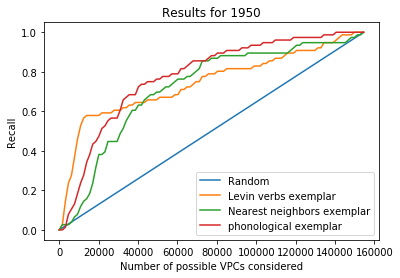


100%|██████████| 101/101 [00:01<00:00, 30.55it/s]


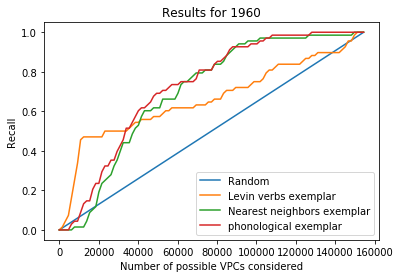


100%|██████████| 101/101 [00:01<00:00, 61.19it/s]

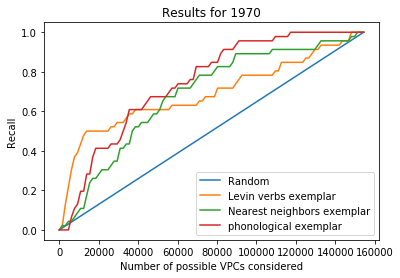


100%|██████████| 101/101 [00:01<00:00, 62.22it/s]

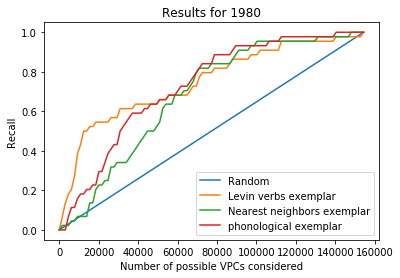


100%|██████████| 101/101 [00:01<00:00, 62.07it/s]

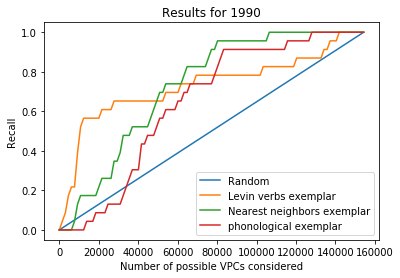

In [39]:
# TODO: In order to have a fair evaluation of the levin verbs method,
# we would need to limit the predictions of the other exemplar methods
# to only select from among levin verbs.

run_experiment(
    [get_ranking_levin_verbs,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking])

100%|██████████| 101/101 [00:02<00:00, 48.12it/s]


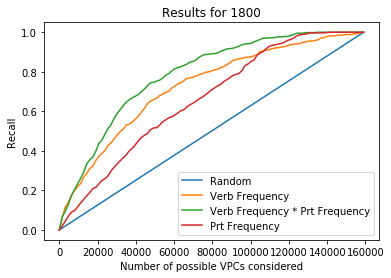

100%|██████████| 101/101 [00:02<00:00, 27.72it/s]


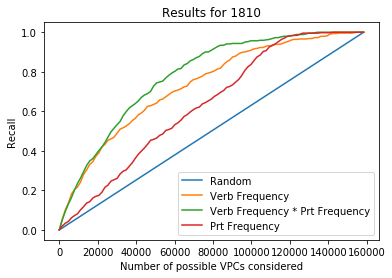

100%|██████████| 101/101 [00:02<00:00, 48.67it/s]


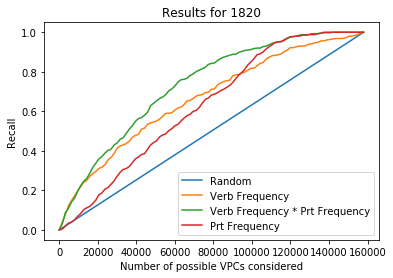

100%|██████████| 101/101 [00:01<00:00, 28.94it/s]


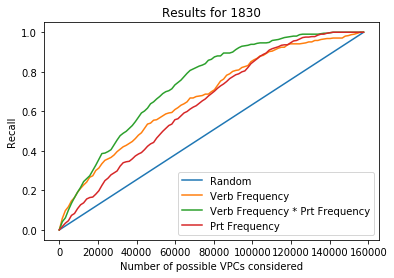

100%|██████████| 101/101 [00:01<00:00, 29.00it/s]


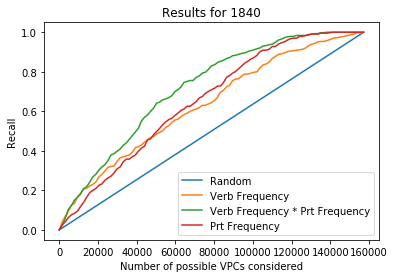

100%|██████████| 101/101 [00:01<00:00, 51.22it/s]


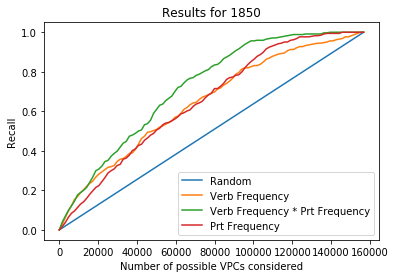

100%|██████████| 101/101 [00:01<00:00, 54.29it/s]


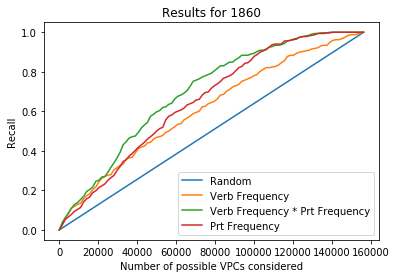

100%|██████████| 101/101 [00:02<00:00, 25.57it/s]


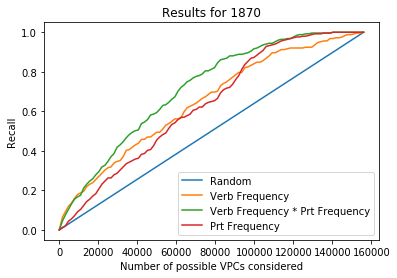

100%|██████████| 101/101 [00:02<00:00, 25.72it/s]


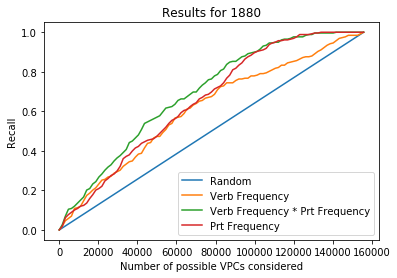

100%|██████████| 101/101 [00:02<00:00, 44.03it/s]


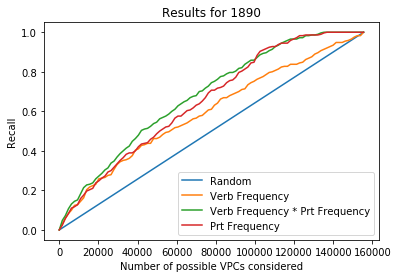

100%|██████████| 101/101 [00:02<00:00, 42.29it/s]


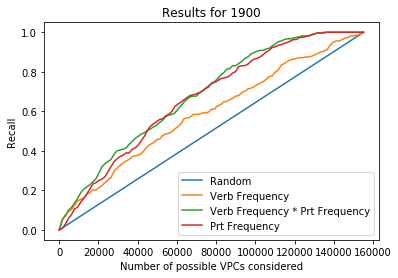

100%|██████████| 101/101 [00:02<00:00, 27.55it/s]


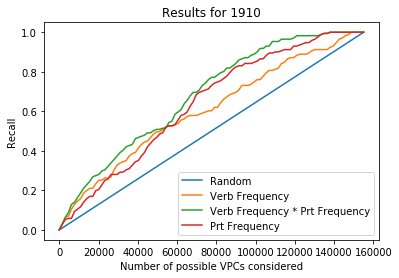

100%|██████████| 101/101 [00:01<00:00, 51.81it/s]


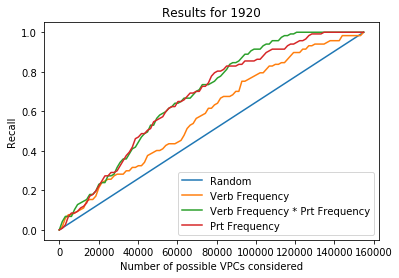

100%|██████████| 101/101 [00:02<00:00, 27.91it/s]


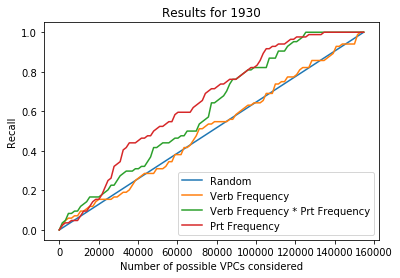

100%|██████████| 101/101 [00:02<00:00, 48.70it/s]


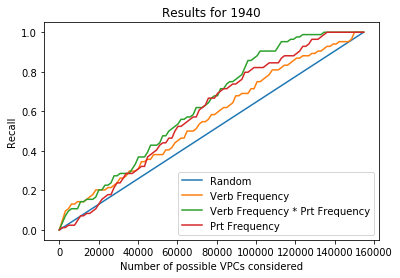

100%|██████████| 101/101 [00:02<00:00, 42.91it/s]


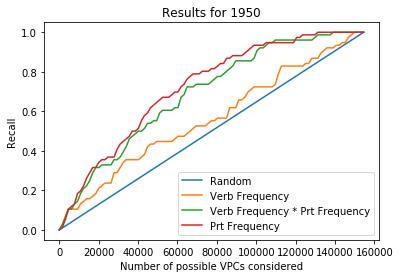

100%|██████████| 101/101 [00:02<00:00, 43.98it/s]


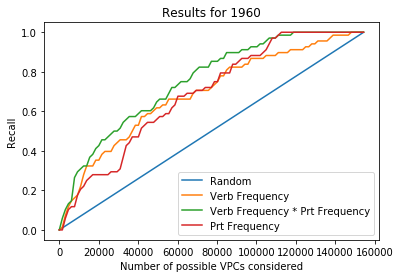

100%|██████████| 101/101 [00:02<00:00, 28.31it/s]


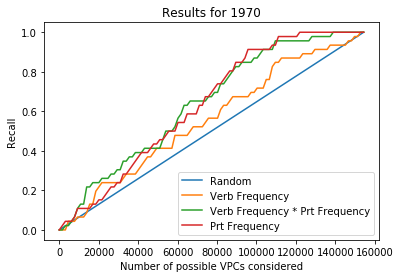

100%|██████████| 101/101 [00:02<00:00, 27.46it/s]


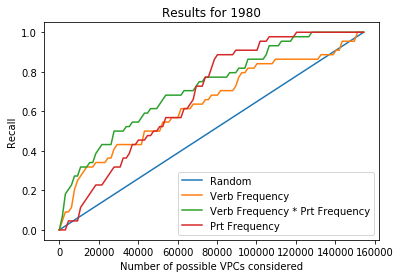

100%|██████████| 101/101 [00:01<00:00, 29.88it/s]


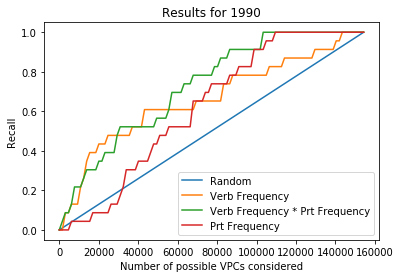

In [94]:
run_experiment(
    [get_verb_frequency_ranking,
     get_verb_particle_frequency_ranking,
     get_particle_frequency_ranking])